### 1. 다양한 시계열 예측 기법 비교
1. SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)
- ARIMA의 확장
- seasonal, non-seasonal data 처리 가능
- X변수 적용 가능
- 중소규모 데이터에 적절
- 모형 파라미터 해석 및 계절적 패턴이 분명할 경우 모델링 성능 우수
- Careful parameter tuning (e.g., p, d, q, P, D, Q).
- Linear relationships 가정: 대규모 데이터 및 비선형 트렌드에서는 성능 저하

2. RNN (Recurrent Neural Networks)
- neural network: 순차적인 데이터를 처리(기존 입력값에 대한 memory), 시계열에 활용
- temporal dependencies를 활용
- univariate & multivariate time series에 활용
- 비선형 패턴/복잡한 패턴 모델링
- long-term dependency : vanishing gradient problems
- 통계 모형 대비 해석이 어려움





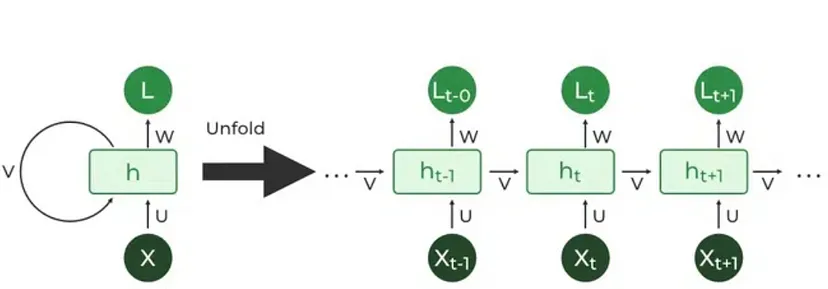

3. LSTM (Long Short-Term Memory Networks)
LSTM networks are a variant of RNNs designed to overcome the vanishing gradient problem, making them more effective at learning long-term dependencies in time series data.

LSTMs are widely used in fields like finance (stock price prediction), healthcare (patient monitoring), and any scenario involving sequential data with complex patterns.

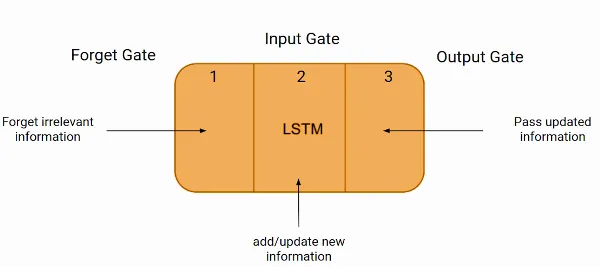

- memory cell을 통해서 long sequence에 대한 정보를 유지
- noisy data, long term dependency 처리
- 다른 모형과 같이 사용
- 계산 비용
- 데이터가 많아야 피팅이 좋음

4. Prophet
- open-source forecasting tool developed by Facebook
- 결측, 이상치, 계절성이 강한 시계열 데이터에 활용
- 사용이 편하며, 파라미터 튜닝이 필요없음
- 비즈니스 예측 등에 많이 활용: 소매 판매, 웹트래픽 등

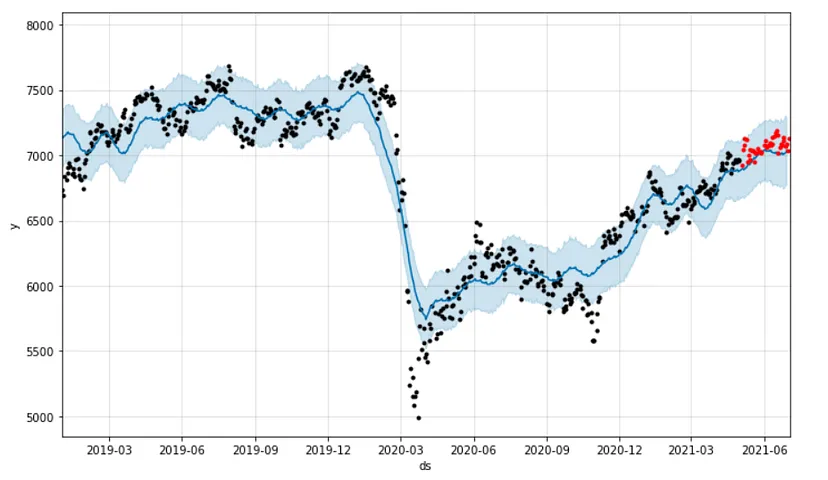

- 자동으로 결측 및 이상치 처리
- 일별/주별/연간 계절성 처리
- 사용이 편리
- 계절성 외 비선형 패턴 처리에 약함

5. Transformer Models
- Transformer models: suquential data 처리가 우수하여 시계열 예측에 적용
 - self-attention mechanisms: 입력 sequence의 각각 다른 파트에 집중
 - energy load forecasting, anomaly detection, other applications에 활용
 - 우수한 성능 및 sequence의 dependency를 잘 처리.

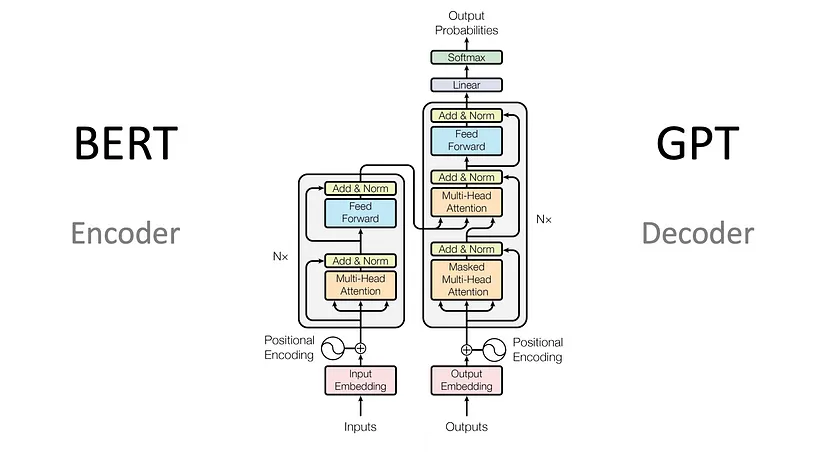

- Self-attention: sequential한 각 값에 다른 가중치를 적용.
- 병렬 처리를 통한 빠른 학습 / long-term dependencies
- 비선형/선형 패턴 모델링
- 작은 데이터인 경우 과적합의 문제 / 해석의 어려움

### Transformer 사용: TimesFM (Foundation Model)
- TimesFM : decoder-only transformer
- Patched-Decoder Style
 - NLP의 토큰 대신 Patch 사용: TimesLM은 시계열 데이터를 patch 단위로 나눔
 - patch: 시계열 값들의 세그먼트, 각 patch가 토큰의 역할
 - 1024개 값의 시계열이 32개 길이의 패치로 나눠질 수 있음, 32개 패치를 처리
 - 토큰의 수를 Transformer 은닉층으로 줄이며 계산

- Flexible Input and Output Patch Lengths
 - Input patches로 입력 시계열의 context를 파악, output patch로는 미래 값을 예측
 - 긴 미래 시점의 값을 예측할 수 있음(예: 128개 값의 예측)
 - 일반화 전략: random masking during training, 패치에 대한 drop out과 같으며, 다양한 context 길이에 모형의 적응력을 높임

- Stacked Transformer Layers
 - self-attention and feedforward networks의 조합
 - causal attention을 통해서 과거 데이터에 의존한 미래 패치의 값을 예측

- 시계열 처리
 - Positional encoding: temporal적인 면을 인식, 시계열 데이터 처리를 지원

- 학습: data diveristy, efficient Processing
 - 다양한 데이터로 미리 학습: 현실 데이터와 현실 데이터 합성을 통해 다양성
 - Google Trends, Wiki Pageviews, Synthetic Data(ARMA processes, seasonal patterns,  step functions 등 포함)

 - Patched Input Processing: 시계열 데이터가 non-overlapping patches로 나눠지며, 각 패치는 임베딩으로 변환
 - Masking During Training: 다양한 context 길이를 지원하기 위한 랜덤 마스킹
 - Loss Function: MSE

- Dataset Mixing Strategy
 - 50–50 split between real and synthetic data.
 - 실제 데이터에 대해서는 가중치가 일별/주별/월별 데이터셋에 동일하게 적용

- zero-shot forecasting ability
 — 학습하지 않았던 데이터에 대해 좋은 성능이 나옴

- Scaling Laws
 - model size, data volume, training compute에 영향
 - NLP와 같이, parameter count와 forecasting accuracy 관계가 있음
 - 예: 17M, 70M, 200M parameters로 학습 시 결과가 지속적으로 개선


In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [83]:
import warnings
warnings.filterwarnings('ignore')

import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
absl_logger = logging.getLogger("absl")
cmdstanpy_logger.disabled = True
absl_logger.disabled = True

In [84]:
# Data loading
temps = pd.read_csv('daily-min-temperatures.csv')

In [85]:
# Conversion of date to datetime format
temps['ds'] = pd.to_datetime(temps['Date'])
temps.drop(columns=['Date'], inplace=True)
temps.rename(columns={'Temp': 'y'},inplace=True)

In [86]:
temps['y'].astype("str").str.replace("?", "0").astype(float)
temps.head()

y         ds
0  20.7 1981-01-01
1  17.9 1981-01-02
2  18.8 1981-01-03
3  14.6 1981-01-04
4  15.8 1981-01-05

In [87]:
# Plotting the evolution of the temperature
fig = px.line(temps, x='ds', y='y')
fig.update_layout(
    title='Evolution of the temperature',
    xaxis_title='Date',
    yaxis_title='Temperature'
)

In [88]:
temps['y'].describe()

count    3650.000000
mean       11.177753
std         4.071837
min         0.000000
25%         8.300000
50%        11.000000
75%        14.000000
max        26.300000
Name: y, dtype: float64

In [89]:
nb_missing_timestamps = len(pd.date_range( start=temps['ds'].min(), end=temps['ds'].max()).difference(temps.ds))
print(str(nb_missing_timestamps) + ' missings timestamps')

2 missings timestamps


In [90]:
missing_dates = pd.date_range(start=temps['ds'].min(), end=temps['ds'].max(), freq='D').difference(temps['ds'])
missing_data = {'ds': missing_dates, 'y': [pd.NA]*len(missing_dates)}
missing_df = pd.DataFrame(missing_data)

temps = pd.concat([temps, missing_df]).sort_values(by='ds').reset_index(drop=True)
temps['y'] = temps['y'].fillna(method='ffill')

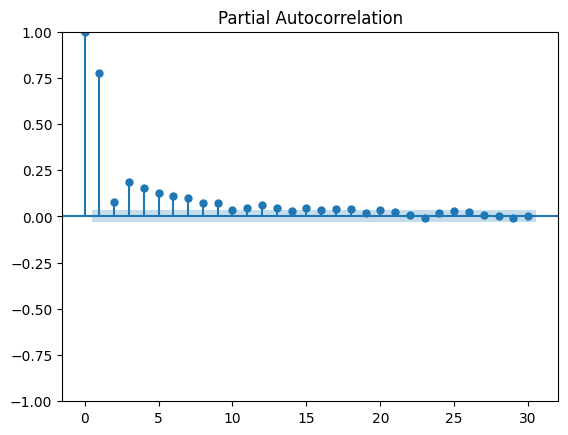

In [91]:
plot_pacf(temps.y,lags = 30);

In [92]:
# Add of the week of the day and the month of the year information
temps['weekday'] = temps['ds'].dt.weekday
temps['month'] = temps['ds'].dt.month

<Axes: xlabel='weekday', ylabel='y'>

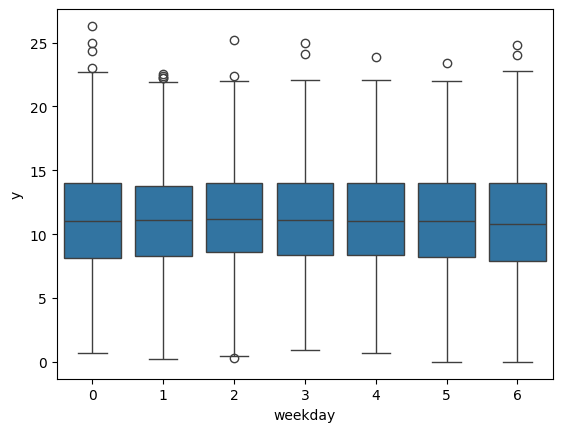

In [93]:
sns.boxplot(x="weekday", y="y", data=temps)

<Axes: xlabel='month', ylabel='y'>

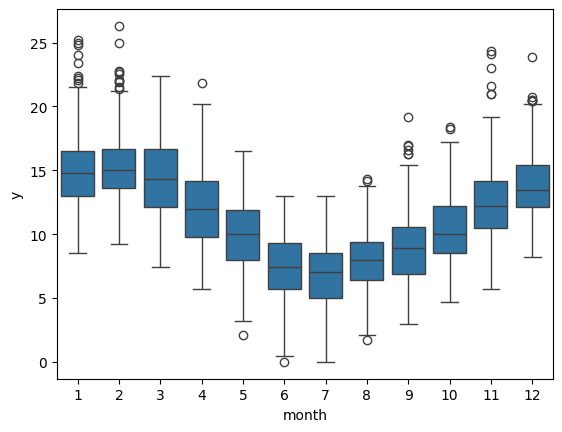

In [94]:
sns.boxplot(x="month", y="y", data=temps)

In [95]:
temps.shape
temps.head()

y         ds  weekday  month
0  20.7 1981-01-01        3      1
1  17.9 1981-01-02        4      1
2  18.8 1981-01-03        5      1
3  14.6 1981-01-04        6      1
4  15.8 1981-01-05        0      1

In [96]:
temps['lag_1'] = temps['y'].shift(1).fillna(0)
temps['lag_7'] = temps['y'].shift(7).fillna(0)

In [97]:
temps

y         ds  weekday  month  lag_1  lag_7
0     20.7 1981-01-01        3      1    0.0    0.0
1     17.9 1981-01-02        4      1   20.7    0.0
2     18.8 1981-01-03        5      1   17.9    0.0
3     14.6 1981-01-04        6      1   18.8    0.0
4     15.8 1981-01-05        0      1   14.6    0.0
...    ...        ...      ...    ...    ...    ...
3647  14.0 1990-12-27        3     12   14.6   15.4
3648  13.6 1990-12-28        4     12   14.0   13.1
3649  13.5 1990-12-29        5     12   13.6   13.2
3650  15.7 1990-12-30        6     12   13.5   13.9
3651  13.0 1990-12-31        0     12   15.7   10.0

[3652 rows x 6 columns]

In [99]:
#window size
window_size=3000
step_size=14
train_data = temps[0 : window_size]
test_data = temps[window_size :]

In [114]:
model = ARIMA(train_data['y'], order=(7, 1, 0))
model_fit = model.fit()
predicted_arima = model_fit.forecast(steps=step_size)

In [110]:
model_prophet = Prophet( yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True)
model_prophet_fit = model_prophet.fit( train_data)
predicted_df = model_prophet_fit.make_future_dataframe(periods=step_size)
predicted_prophet = model_prophet_fit.predict(predicted_df)
predicted_prophet['yhat'].tail(step_size)

3000    13.303089
3001    13.306923
3002    13.310757
3003    13.314591
3004    13.318425
3005    13.322259
3006    13.326093
3007    13.329927
3008    13.333761
3009    13.337595
3010    13.341429
3011    13.345263
3012    13.349097
3013    13.352932
Name: yhat, dtype: float64

In [118]:
model_lr = LinearRegression()
model_lr_fit = model_lr.fit(train_data[['lag_1', 'lag_7', 'weekday', 'month']], train_data['y'])
predicted_lr = model_lr_fit.predict(test_data[['lag_1', 'lag_7', 'weekday', 'month']])

In [119]:
model_rf = RandomForestRegressor()
model_rf_fit = model_rf.fit(train_data[['lag_1', 'lag_7', 'weekday', 'month']], train_data['y'])
predicted_rf = model_rf_fit.predict(test_data[['lag_1', 'lag_7', 'weekday', 'month']])

#비교

In [115]:
predicted_arima

3000    15.029236
3001    14.406207
3002    14.239640
3003    14.184614
3004    14.130115
3005    13.975117
3006    14.023072
3007    14.236916
3008    14.302677
3009    14.248663
3010    14.197487
3011    14.173636
3012    14.165586
3013    14.161021
Name: predicted_mean, dtype: float64

In [116]:
predicted_prophet

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    1981-01-01  19.064686    7.856529   17.682673    19.064686    19.064686   
1    1981-01-02  19.061108    7.649794   17.995901    19.061108    19.061108   
2    1981-01-03  19.057531    7.290604   17.285882    19.057531    19.057531   
3    1981-01-04  19.053953    7.126924   17.771003    19.053953    19.053953   
4    1981-01-05  19.050376    7.509479   17.625196    19.050376    19.050376   
...         ...        ...         ...         ...          ...          ...   
3009 1989-03-29  19.797633    8.188867   18.305854    19.797633    19.797633   
3010 1989-03-30  19.801467    8.234382   18.564910    19.801467    19.801467   
3011 1989-03-31  19.805301    8.157491   18.310133    19.805301    19.805301   
3012 1989-04-01  19.809135    8.302109   18.641561    19.809135    19.809135   
3013 1989-04-02  19.812969    7.840796   18.563878    19.812969    19.812969   

      additive_terms  additive_terms_lower  additive_terms_upper     daily  \
0          -6.460037             -6.460037             -6.460037 -6.460037   
1          -6.460037             -6.460037             -6.460037 -6.460037   
2          -6.460037             -6.460037             -6.460037 -6.460037   
3          -6.460037             -6.460037             -6.460037 -6.460037   
4          -6.460037             -6.460037             -6.460037 -6.460037   
...              ...                   ...                   ...       ...   
3009       -6.460037             -6.460037             -6.460037 -6.460037   
3010       -6.460037             -6.460037             -6.460037 -6.460037   
3011       -6.460037             -6.460037             -6.460037 -6.460037   
3012       -6.460037             -6.460037             -6.460037 -6.460037   
3013       -6.460037             -6.460037             -6.460037 -6.460037   

      daily_lower  daily_upper  multiplicative_terms  \
0       -6.460037    -6.460037                   0.0   
1       -6.460037    -6.460037                   0.0   
2       -6.460037    -6.460037                   0.0   
3       -6.460037    -6.460037                   0.0   
4       -6.460037    -6.460037                   0.0   
...           ...          ...                   ...   
3009    -6.460037    -6.460037                   0.0   
3010    -6.460037    -6.460037                   0.0   
3011    -6.460037    -6.460037                   0.0   
3012    -6.460037    -6.460037                   0.0   
3013    -6.460037    -6.460037                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                            0.0                         0.0  12.604648  
1                            0.0                         0.0  12.601071  
2                            0.0                         0.0  12.597493  
3                            0.0                         0.0  12.593916  
4                            0.0                         0.0  12.590338  
...                          ...                         ...        ...  
3009                         0.0                         0.0  13.337595  
3010                         0.0                         0.0  13.341429  
3011                         0.0                         0.0  13.345263  
3012                         0.0                         0.0  13.349097  
3013                         0.0                         0.0  13.352932  

[3014 rows x 16 columns]

In [120]:
predicted_lr

array([14.25491609, 15.999318  , 16.075885  , 15.73926563, 14.95410086,
       13.08851606, 13.21769381, 11.30135123, 11.36368437, 12.77426736,
       11.74325343, 10.7428696 , 12.50789067, 12.27608861, 13.71010104,
       13.47482978, 13.19514588, 16.33567948, 12.44253966, 13.58096811,
       12.33559064, 13.72906382, 13.42694794, 15.43917967, 13.3385575 ,
       13.64241508, 12.4815853 ,  9.88494009, 11.95857396, 11.90100039,
       12.34719665, 10.08265934, 10.11868709,  9.71738545, 10.57546125,
       10.45420288,  9.61597603, 10.77296307, 11.39771254, 12.84883477,
       14.10198969, 13.13696486, 12.20779054, 13.29531927, 13.67638194,
       12.15281418, 14.14090289, 11.2389065 , 10.91048523, 11.641905  ,
       11.4747852 , 10.2936858 , 12.6837449 , 12.74738488, 12.03208261,
       11.55226903, 11.39952504, 10.06703332,  9.62257875,  9.65946203,
       11.82439291, 11.58223038,  8.68626974,  7.17018652, 10.71787075,
        9.65537121, 10.04030727, 10.97473265,  9.09018507,  9.46

In [121]:
predicted_rf

array([14.        , 16.069     , 15.745     , 15.164     , 15.236     ,
       13.581     , 14.123     , 10.74      , 10.78      , 12.737     ,
       11.994     , 12.177     , 10.552     , 12.418     , 13.079     ,
       13.872     , 12.213     , 17.915     , 11.349     , 12.93      ,
       11.51      , 11.752     , 12.575     , 13.314     , 12.304     ,
       14.059     , 11.713     ,  9.764     , 10.182     , 11.478     ,
       12.72      , 10.632     ,  9.276     ,  8.333     , 11.69      ,
       10.759     ,  9.016     , 10.903     , 12.003     , 12.421     ,
       12.932     , 13.652     , 10.501     , 13.514     , 14.107     ,
       11.065     , 12.223     ,  9.781     ,  9.615     ,  8.907     ,
        9.975     , 11.028     , 11.377     , 13.185     , 10.731     ,
       12.13      ,  9.983     ,  9.411     ,  7.62      ,  9.572     ,
       11.346     , 11.194     ,  7.39      ,  7.96      , 10.124     ,
        8.939     ,  7.966     , 11.1742    ,  9.328     ,  8.97

In [122]:
mean_squared_error( test_data['y'], predicted_rf, squared=False)

2.347035392705991

In [124]:
mean_squared_error( test_data['y'], predicted_lr, squared=False)

2.3041758094485445

In [132]:
mean_squared_error( test_data.y[0:14], predicted_prophet.trend[3000:3014], squared=False)

7.061723274188483

In [133]:
mean_squared_error( test_data.y[0:14], predicted_arima, squared=False)

2.8685967277223274